### 🔧 Model Definition – CrossViT
Defines the CrossViT architecture used for multimodal fusion of RGB and thermal images. CrossViT enables attention-based fusion of local (CNN-like) and global (transformer) features for robust fire classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os

# Import the CrossViT model (make sure crossvit.py is in the repo)
from crossvit import CrossViT

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [3]:
import torchvision.transforms as T

# --- Augmentation for Training Data ---
# Aggressive augmentations to increase training data diversity.
train_transform_rgb = T.Compose([
    T.Resize((256, 256)),                  # Resize to a larger size for cropping
    T.RandomResizedCrop(224),              # Random crop to 224x224
    T.RandomHorizontalFlip(),              # Horizontal flip with 50% probability
    T.RandomRotation(15),                  # Random rotation up to 15 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter for variation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

train_transform_thermal = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor()
])

# --- Transformations for Validation Data ---
# Minimal augmentation: only resizing and normalization for consistent evaluation.
val_transform_rgb = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

val_transform_thermal = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# --- Transformations for Test Data ---
# Similar to validation. Alternatively, you can use Test Time Augmentation (TTA) here if desired.
test_transform_rgb = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

test_transform_thermal = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])


In [5]:
class WildfireDataset(Dataset):
    def __init__(self, root_dir, transform_rgb=None, transform_thermal=None):
        self.samples = []
        self.transform_rgb = transform_rgb
        self.transform_thermal = transform_thermal
        
        classes = {'Fire': 1, 'No Fire': 0}
        for cls in classes.keys():
            cls_dir = os.path.join(root_dir, cls)
            rgb_dir = os.path.join(cls_dir, 'RGB')
            thermal_dir = os.path.join(cls_dir, 'Thermal')
            
            if os.path.exists(rgb_dir) and os.path.exists(thermal_dir):
                for fname in os.listdir(rgb_dir):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff')):
                        rgb_path = os.path.join(rgb_dir, fname)
                        thermal_path = os.path.join(thermal_dir, fname)
                        if os.path.exists(thermal_path):
                            self.samples.append((rgb_path, thermal_path, classes[cls]))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        rgb_path, thermal_path, label = self.samples[index]
        
        # Load images
        from PIL import Image
        rgb_image = Image.open(rgb_path).convert('RGB')
        thermal_image = Image.open(thermal_path).convert('L')
        
        if self.transform_rgb:
            rgb_image = self.transform_rgb(rgb_image)
        if self.transform_thermal:
            thermal_image = self.transform_thermal(thermal_image)
        else:
            from torchvision.transforms import ToTensor
            thermal_image = ToTensor()(thermal_image)
        
        # Concatenate: 3 channels (RGB) + 1 channel (Thermal) = 4 channels
        combined = torch.cat((rgb_image, thermal_image), dim=0)
        return combined, label


### 📦 Data Loading and Preprocessing
This section prepares the input data by loading RGB and thermal image pairs into training and validation data loaders. The data is normalized and structured into a format compatible with PyTorch models.

In [7]:
# Update these paths to point to your actual train, validation, and test directories.
train_dataset = WildfireDataset(
    root_dir='D:/SEM 2 ASU/CSE 572 DATA MINING/Data_split/train',
    transform_rgb=train_transform_rgb,
    transform_thermal=train_transform_thermal
)

val_dataset = WildfireDataset(
    root_dir='D:/SEM 2 ASU/CSE 572 DATA MINING/Data_split/val',
    transform_rgb=val_transform_rgb,
    transform_thermal=val_transform_thermal
)

test_dataset = WildfireDataset(
    root_dir='D:/SEM 2 ASU/CSE 572 DATA MINING/Data_split/test',
    transform_rgb=test_transform_rgb,
    transform_thermal=test_transform_thermal
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Train samples: 352
Validation samples: 13
Test samples: 15


### 🔧 Model Definition – CrossViT
Defines the CrossViT architecture used for multimodal fusion of RGB and thermal images. CrossViT enables attention-based fusion of local (CNN-like) and global (transformer) features for robust fire classification.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define number of classes and instantiate the model
num_classes = 2
model = CrossViT(image_size=224, channels=4, num_classes=num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(model)


CrossViT(
  (to_patch_embedding_small): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14)
    (1): Linear(in_features=784, out_features=96, bias=True)
  )
  (to_patch_embedding_large): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=1024, out_features=192, bias=True)
  )
  (dropout_small): Dropout(p=0.0, inplace=False)
  (dropout_large): Dropout(p=0.0, inplace=False)
  (multi_scale_transformers): ModuleList(
    (0-2): 3 x MultiScaleTransformerEncoder(
      (transformer_enc_small): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): Attention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Sequential(
                  (0): Linear(in_features=96, out_features=96, bias=True)
               

### 📦 Data Loading and Preprocessing
This section prepares the input data by loading RGB and thermal image pairs into training and validation data loaders. The data is normalized and structured into a format compatible with PyTorch models.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

# Assume these are defined: device, CrossViT, train_dataset
num_folds = 5
num_epochs = 5
batch_size = 8
num_classes = 2  # Adjust based on your problem

# Create a list of indices for the dataset
dataset_size = len(train_dataset)
indices = list(range(dataset_size))

# Initialize KFold with shuffling
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# To store metrics for each fold (each fold stores per-epoch metrics)
all_fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n\n----- Fold {fold+1}/{num_folds} -----")
    
    # Create subsets for training and validation
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    # Create DataLoaders for this fold (using num_workers=0 for stability)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize a fresh instance of the model for each fold
    model = CrossViT(image_size=224, channels=4, num_classes=num_classes).to(device)
    
    # Define loss function and optimizer (with weight decay for regularization)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # Optionally, set up a learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Lists to collect per-epoch metrics for this fold
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        # ----- Training Phase -----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
        epoch_train_loss = running_loss / total
        epoch_train_acc = 100.0 * correct / total
        print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        
        # ----- Validation Phase -----
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
        
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = 100.0 * val_correct / val_total
        print(f"             Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        
        # Store metrics for this epoch
        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)
        
        scheduler.step()  # update learning rate if needed
    
    # Save the model for this fold
    model_save_path = f"model_fold_{fold+1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model for Fold {fold+1} saved to {model_save_path}")
    
    # Store fold metrics
    fold_metric = {
        'fold': fold+1,
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list
    }
    all_fold_metrics.append(fold_metric)

# Optionally, print final fold results
print("\nCross-Validation Final Metrics per Fold:")
for fold_metric in all_fold_metrics:
    print(f"Fold {fold_metric['fold']}: Final Train Acc = {fold_metric['train_acc'][-1]:.2f}%, Final Val Acc = {fold_metric['val_acc'][-1]:.2f}%")




----- Fold 1/5 -----
Fold 1, Epoch 1/5 - Train Loss: 0.2502, Train Acc: 90.75%
             Val Loss: 0.0923, Val Acc: 95.77%
Fold 1, Epoch 2/5 - Train Loss: 0.0704, Train Acc: 97.15%
             Val Loss: 0.1109, Val Acc: 94.37%
Fold 1, Epoch 3/5 - Train Loss: 0.1023, Train Acc: 95.73%
             Val Loss: 0.1224, Val Acc: 91.55%
Fold 1, Epoch 4/5 - Train Loss: 0.1036, Train Acc: 96.09%
             Val Loss: 0.0335, Val Acc: 98.59%
Fold 1, Epoch 5/5 - Train Loss: 0.0498, Train Acc: 98.22%
             Val Loss: 0.0233, Val Acc: 98.59%
Model for Fold 1 saved to model_fold_1.pt


----- Fold 2/5 -----
Fold 2, Epoch 1/5 - Train Loss: 0.3027, Train Acc: 87.54%
             Val Loss: 0.0424, Val Acc: 98.59%
Fold 2, Epoch 2/5 - Train Loss: 0.0985, Train Acc: 96.09%
             Val Loss: 0.0726, Val Acc: 95.77%
Fold 2, Epoch 3/5 - Train Loss: 0.1016, Train Acc: 96.80%
             Val Loss: 0.1436, Val Acc: 94.37%
Fold 2, Epoch 4/5 - Train Loss: 0.0921, Train Acc: 96.44%
             V

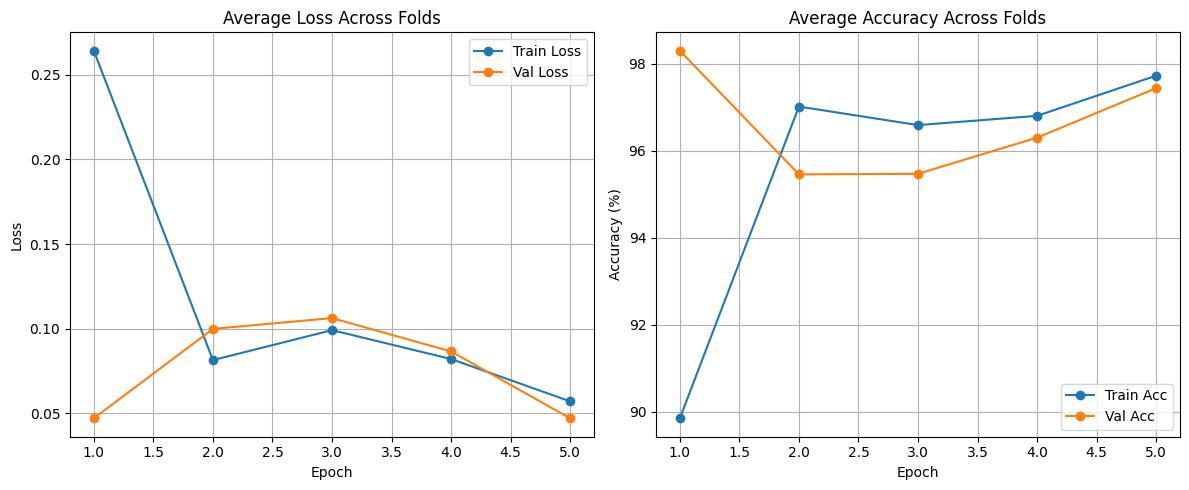

In [13]:
import matplotlib.pyplot as plt

# Assuming all_fold_metrics is a list of dictionaries containing per-epoch metrics
num_epochs = len(all_fold_metrics[0]['train_loss'])
num_folds = len(all_fold_metrics)

# Initialize arrays to accumulate metrics for averaging
avg_train_loss = np.zeros(num_epochs)
avg_val_loss = np.zeros(num_epochs)
avg_train_acc = np.zeros(num_epochs)
avg_val_acc = np.zeros(num_epochs)

for fold_metric in all_fold_metrics:
    avg_train_loss += np.array(fold_metric['train_loss'])
    avg_val_loss += np.array(fold_metric['val_loss'])
    avg_train_acc += np.array(fold_metric['train_acc'])
    avg_val_acc += np.array(fold_metric['val_acc'])

avg_train_loss /= num_folds
avg_val_loss /= num_folds
avg_train_acc /= num_folds
avg_val_acc /= num_folds

epochs = np.arange(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Plot Loss Curves
plt.subplot(1,2,1)
plt.plot(epochs, avg_train_loss, label='Train Loss', marker='o')
plt.plot(epochs, avg_val_loss, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Across Folds')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1,2,2)
plt.plot(epochs, avg_train_acc, label='Train Acc', marker='o')
plt.plot(epochs, avg_val_acc, label='Val Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy Across Folds')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 🔧 Model Definition – CrossViT
Defines the CrossViT architecture used for multimodal fusion of RGB and thermal images. CrossViT enables attention-based fusion of local (CNN-like) and global (transformer) features for robust fire classification.

In [14]:
# Assume test_dataset is defined and prepared similar to train_dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Reinitialize the model with the same architecture and load the saved state (using fold 1 for demonstration)
model = CrossViT(image_size=224, channels=4, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("model_fold_1.pt"))
model.eval()  # Set model to evaluation mode

# Define the criterion (should be the same as used in training)
criterion = nn.CrossEntropyLoss()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

final_test_loss = test_loss / test_total
final_test_acc = 100.0 * test_correct / test_total

print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc:.2f}%")


Test Loss: 0.1094, Test Accuracy: 86.67%


### 📊 Model Evaluation and Metrics
Evaluates model predictions on the validation set using accuracy, precision, recall, F1-score, and confusion matrix.

In [19]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Assuming model predictions and true labels are collected here
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:  # Or test_loader if available
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_true = np.array(all_true)

# Compute metrics
print("Accuracy:", accuracy_score(all_true, all_preds))
print("Precision:", precision_score(all_true, all_preds, average='weighted'))
print("Recall:", recall_score(all_true, all_preds, average='weighted'))
print("F1 Score:", f1_score(all_true, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_true, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_true, all_preds))


Accuracy: 0.9857142857142858
Precision: 0.985956416464891
Recall: 0.9857142857142858
F1 Score: 0.9854647767691246

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.98      1.00      0.99        58

    accuracy                           0.99        70
   macro avg       0.99      0.96      0.97        70
weighted avg       0.99      0.99      0.99        70


Confusion Matrix:
 [[11  1]
 [ 0 58]]


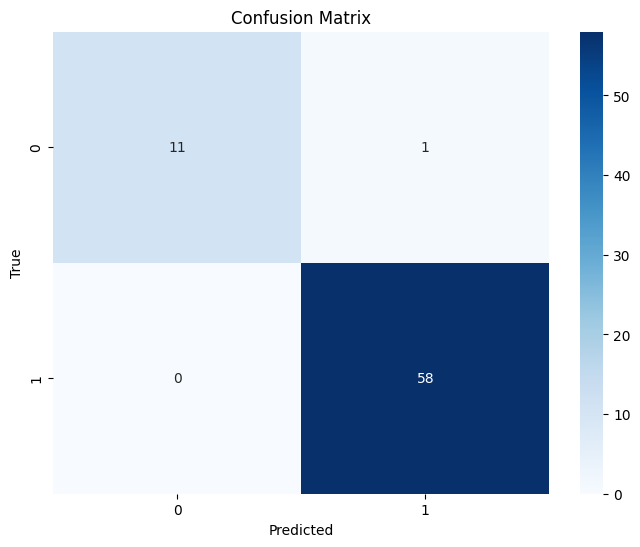

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# --- Plot Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- ROC-AUC Curve (multi-class) ---
num_classes = len(np.unique(all_true))
all_true_bin = label_binarize(all_true, classes=np.arange(num_classes))
all_preds_proba = []

# Get predicted probabilities
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds_proba.extend(probs.cpu().numpy())

all_preds_proba = np.array(all_preds_proba)



### 🔧 Model Definition – CrossViT
Defines the CrossViT architecture used for multimodal fusion of RGB and thermal images. CrossViT enables attention-based fusion of local (CNN-like) and global (transformer) features for robust fire classification.

In [25]:
import torch
import torchvision.transforms as T
from PIL import Image

# Assuming these variables are defined:
# device (e.g., torch.device('cuda') or 'cpu'),
# num_classes (set to 2 for binary classification),
# and CrossViT (the model architecture).
# Also, ensure that your saved model file (e.g., "model_fold_1.pt") exists.

# Define test transforms for RGB and thermal images
test_transform_rgb = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform_thermal = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Prompt the user to provide file paths for the RGB and thermal images
rgb_path = input("Enter the path to the RGB image: ")
thermal_path = input("Enter the path to the thermal image: ")

# Load images using PIL
rgb_image = Image.open(rgb_path).convert('RGB')
thermal_image = Image.open(thermal_path).convert('L')  # Convert thermal image to grayscale

# Apply transforms
rgb_tensor = test_transform_rgb(rgb_image)
thermal_tensor = test_transform_thermal(thermal_image)

# Concatenate the tensors along the channel dimension: 3 (RGB) + 1 (thermal) = 4 channels
input_tensor = torch.cat((rgb_tensor, thermal_tensor), dim=0)
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension; resulting shape: [1, 4, 224, 224]

# Initialize and load the saved model (example uses the model saved farom fold 1)
model = CrossViT(image_size=224, channels=4, num_classes=2).to(device)
model.load_state_dict(torch.load("model_fold_1.pt", map_location=device))
model.eval()

# Run inference on the user-provided image
with torch.no_grad():
    outputs = model(input_tensor.to(device))
    _, prediction = torch.max(outputs, 1)

# Map numeric prediction to a human-readable label
label_mapping = {0: "No Fire", 1: "Fire"}
predicted_label = label_mapping[prediction.item()]

print(f"Predicted Label: {predicted_label}")


Enter the path to the RGB image:  t
Enter the path to the thermal image:  t


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HP ZBOOK FURY G7\\Downloads\\DM proj\\t'

In [43]:
latent_features = []  # Global list to store features

def hook_fn(module, input, output):
    print("Hook triggered! Output shape:", output.shape)
    latent_features.append(output.detach().cpu())

# Register the hook on the 'to_latent' layer
# Option 1: Hook on mlp_head_small's first layer
hook_handle = model.mlp_head_small[0].register_forward_hook(hook_fn)



In [27]:
# 1. (Optional) Inspect the model architecture
for name, module in model.named_modules():
    print(name)

# 2. Define a global list and the hook function with a debug print.
latent_features = []

def hook_fn(module, input, output):
    print("✅ Hook triggered at {}! Output shape: {}".format(module.__class__.__name__, output.shape))
    latent_features.append(output.detach().cpu())

# 3. Register the hook on the alternative module.
# Change this as needed if you prefer a different module (e.g., mlp_head_large).
hook_handle = model.mlp_head_small.register_forward_hook(hook_fn)

# 4. Run inference and capture features.
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        latent_features.clear()  # Clear before each forward pass
        
        _ = model(images)  # Forward pass; hook should be triggered if mlp_head_small is used
        
        if len(latent_features) == 0:
            print("⚠️ Hook did not trigger for this batch. Check the hook registration!")
            continue
        
        batch_features = latent_features[0]  # Grab the captured features
        all_features.append(batch_features)
        all_labels.append(labels)

if all_features:
    X_tensor = torch.cat(all_features, dim=0)
    y_tensor = torch.cat(all_labels, dim=0)
    print("Extracted feature shape:", X_tensor.shape)
else:
    print("No latent features were captured. Please verify the hook registration and model usage.")



to_patch_embedding_small
to_patch_embedding_small.0
to_patch_embedding_small.1
to_patch_embedding_large
to_patch_embedding_large.0
to_patch_embedding_large.1
dropout_small
dropout_large
multi_scale_transformers
multi_scale_transformers.0
multi_scale_transformers.0.transformer_enc_small
multi_scale_transformers.0.transformer_enc_small.layers
multi_scale_transformers.0.transformer_enc_small.layers.0
multi_scale_transformers.0.transformer_enc_small.layers.0.0
multi_scale_transformers.0.transformer_enc_small.layers.0.0.norm
multi_scale_transformers.0.transformer_enc_small.layers.0.0.fn
multi_scale_transformers.0.transformer_enc_small.layers.0.0.fn.to_qkv
multi_scale_transformers.0.transformer_enc_small.layers.0.0.fn.to_out
multi_scale_transformers.0.transformer_enc_small.layers.0.0.fn.to_out.0
multi_scale_transformers.0.transformer_enc_small.layers.0.0.fn.to_out.1
multi_scale_transformers.0.transformer_enc_small.layers.0.1
multi_scale_transformers.0.transformer_enc_small.layers.0.1.norm
m

### 🔧 Model Definition – CrossViT
Defines the CrossViT architecture used for multimodal fusion of RGB and thermal images. CrossViT enables attention-based fusion of local (CNN-like) and global (transformer) features for robust fire classification.

In [28]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model = CrossViT(image_size=224, channels=4, num_classes=num_classes).to(device)

# Global variable to store latent features
latent_features = []

# Define a hook function
def hook_fn(module, input, output):
    # Here, output is the latent representation from the 'to_latent' layer.
    latent_features.append(output.detach().cpu())

# Register hook on the 'to_latent' layer.
# In your model architecture, "to_latent" is an attribute.
hook_handle = model.mlp_head_small.register_forward_hook(hook_fn)


In [31]:
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        # Clear the latent_features list for each batch
        latent_features.clear()
        _ = model(images)  # This will populate latent_features via the hook.
        # Assume the hook returns a tensor of shape [batch_size, feature_dim]
        batch_features = latent_features[0]  # Grab the output from the hook.
        all_features.append(batch_features)
        all_labels.append(labels)

# Concatenate all batches
import torch
X_tensor = torch.cat(all_features, dim=0)
y_tensor = torch.cat(all_labels, dim=0)

# Convert to numpy arrays for scikit-learn usage
X = X_tensor.numpy()  # shape: [N, feature_dim]
y = y_tensor.numpy()
print("Extracted feature shape:", X.shape)


Extracted feature shape: (282, 2)


In [33]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Number of features (assuming X.shape[1] gives feature_dim)
n_features = X.shape[1]

def evaluate_candidate(candidate, X, y):
    """Evaluate candidate mask: select features where candidate==1 and compute CV accuracy."""
    selected_idx = np.where(candidate == 1)[0]
    # Avoid an empty feature subset
    if len(selected_idx) == 0:
        return 0.0
    X_selected = X[:, selected_idx]
    clf = LogisticRegression(solver='liblinear', max_iter=200)
    scores = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')
    return np.mean(scores)

# GA parameters
pop_size = 20
n_generations = 10
mutation_rate = 0.1

# Initialize population: each candidate is a binary vector of length n_features.
population = [np.random.randint(0, 2, size=n_features) for _ in range(pop_size)]

def crossover(parent1, parent2):
    """Perform uniform crossover."""
    child = np.where(np.random.rand(n_features) < 0.5, parent1, parent2)
    return child

def mutate(candidate, mutation_rate):
    """Mutate candidate by flipping bits with given probability."""
    for i in range(len(candidate)):
        if np.random.rand() < mutation_rate:
            candidate[i] = 1 - candidate[i]
    return candidate

# Run the GA loop.
best_candidate = None
best_fitness = 0

for gen in range(n_generations):
    # Evaluate population
    fitnesses = [evaluate_candidate(candidate, X, y) for candidate in population]
    print(f"Generation {gen+1} - Best fitness: {np.max(fitnesses):.4f}, Avg fitness: {np.mean(fitnesses):.4f}")
    
    # Find the best candidate in current generation
    best_idx = np.argmax(fitnesses)
    if fitnesses[best_idx] > best_fitness:
        best_fitness = fitnesses[best_idx]
        best_candidate = population[best_idx].copy()
    
    # Selection: use tournament selection
    new_population = []
    for _ in range(pop_size):
        # Randomly choose two candidates and select the better one.
        i, j = np.random.choice(pop_size, 2, replace=False)
        if fitnesses[i] > fitnesses[j]:
            winner = population[i].copy()
        else:
            winner = population[j].copy()
        new_population.append(winner)
    
    # Crossover
    next_population = []
    for i in range(0, pop_size, 2):
        parent1 = new_population[i]
        parent2 = new_population[(i+1) % pop_size]
        child1 = crossover(parent1, parent2)
        child2 = crossover(parent2, parent1)
        next_population.extend([child1, child2])
    
    # Mutation
    population = [mutate(candidate, mutation_rate) for candidate in next_population]
    
print("Best candidate mask found with fitness:", best_fitness)
selected_features = np.where(best_candidate == 1)[0]
print("Number of selected features:", len(selected_features))


Generation 1 - Best fitness: 0.8722, Avg fitness: 0.5982
Generation 2 - Best fitness: 0.8722, Avg fitness: 0.7734
Generation 3 - Best fitness: 0.8722, Avg fitness: 0.8652
Generation 4 - Best fitness: 0.8722, Avg fitness: 0.8629
Generation 5 - Best fitness: 0.8722, Avg fitness: 0.8233
Generation 6 - Best fitness: 0.8722, Avg fitness: 0.8652
Generation 7 - Best fitness: 0.8722, Avg fitness: 0.8656
Generation 8 - Best fitness: 0.8722, Avg fitness: 0.8670
Generation 9 - Best fitness: 0.8722, Avg fitness: 0.8701
Generation 10 - Best fitness: 0.8722, Avg fitness: 0.8707
Best candidate mask found with fitness: 0.8722431077694235
Number of selected features: 2


In [35]:
print("Feature matrix X:")
print(X)


Feature matrix X:
[[-2.81297892e-01  1.76353276e-01]
 [-4.00657773e-01  2.36038387e-01]
 [-3.38418782e-01 -1.41949773e-01]
 [-1.81777507e-01 -8.76959413e-02]
 [-3.40006888e-01  2.98003733e-01]
 [-6.48720026e-01  6.68726027e-01]
 [-8.35167527e-01  6.94060922e-01]
 [-2.85671711e-01 -4.24882360e-02]
 [-3.70076746e-01 -1.67258307e-02]
 [-6.14128411e-01 -1.10365249e-01]
 [-1.00912559e+00  6.93131462e-02]
 [-4.58284914e-01 -2.36516923e-01]
 [-8.13948750e-01  6.66629970e-01]
 [-6.34532869e-01  5.55449188e-01]
 [ 2.28214115e-01  6.89673960e-01]
 [-7.08165586e-01  7.38497972e-01]
 [-6.30742311e-01  7.47900605e-01]
 [-2.54981637e-01 -3.73021722e-01]
 [-2.75441021e-01 -4.01899964e-01]
 [-3.73685718e-01 -3.95689905e-02]
 [-4.63813484e-01 -4.66738462e-01]
 [-1.01607609e+00 -1.83497891e-02]
 [-3.91516209e-01  4.76999044e-01]
 [-2.18090862e-01 -2.89960504e-01]
 [-6.50555968e-01  6.95536137e-01]
 [-6.46976411e-01  7.20889091e-01]
 [-1.57452822e-01 -3.88244480e-01]
 [-6.20856702e-01  4.89519477e-01]
 [

In [37]:
print("Shape of feature matrix X:", X.shape)
print("First 5 samples:")
print(X[:5])


Shape of feature matrix X: (282, 2)
First 5 samples:
[[-0.2812979   0.17635328]
 [-0.40065777  0.23603839]
 [-0.33841878 -0.14194977]
 [-0.1817775  -0.08769594]
 [-0.3400069   0.29800373]]


In [39]:
print("Best candidate mask found with fitness:", best_fitness)
selected_features = np.where(best_candidate == 1)[0]
print("Number of selected features:", len(selected_features))
print("Selected feature indices:", selected_features)


Best candidate mask found with fitness: 0.8722431077694235
Number of selected features: 2
Selected feature indices: [0 1]


In [41]:
X_selected = X[:, selected_features]
print("Shape of selected feature matrix:", X_selected.shape)
print("Selected feature matrix (first 5 samples):")
print(X_selected[:5])


Shape of selected feature matrix: (282, 2)
Selected feature matrix (first 5 samples):
[[-0.2812979   0.17635328]
 [-0.40065777  0.23603839]
 [-0.33841878 -0.14194977]
 [-0.1817775  -0.08769594]
 [-0.3400069   0.29800373]]


### 📊 Model Evaluation and Metrics
Evaluates model predictions on the validation set using accuracy, precision, recall, F1-score, and confusion matrix.

In [47]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Select features from the feature matrix
X_selected = X[:, selected_features]

# Optionally, split the dataset for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

final_classifiers = {
    'Logistic Regression': LogisticRegression(
                                solver='liblinear', 
                                max_iter=200, 
                                C=0.1, 
                                penalty='l2', 
                                multi_class='ovr'),
    'Random Forest': RandomForestClassifier(
                                n_estimators=500, 
                                max_depth=5, 
                                min_samples_split=4,
                                min_samples_leaf=2,
                                max_features='sqrt', 
                                criterion='gini', 
                                random_state=42),
    'Support Vector Machine': SVC(
                                kernel='poly', 
                                C=1.0, 
                                gamma='scale',
                                degree=3,
                                coef0=0.0, 
                                probability=True, 
                                random_state=42),
    'Decision Tree': DecisionTreeClassifier(
                                max_depth=5, 
                                criterion='entropy', 
                                min_samples_split=4,
                                min_samples_leaf=2,
                                splitter='best',
                                random_state=42)
}

for clf_name, clf in final_classifiers.items():
    print(f"--- {clf_name} ---")
    
    # Cross-validation
    scores = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {np.mean(scores):.4f}")

    # Train and evaluate
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Precision, Recall, F1
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Classification Report and Confusion Matrix
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
Cross-Validation Accuracy: 0.8404
Test Accuracy: 0.8421
Precision: 0.7091, Recall: 0.8421, F1-score: 0.7699
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.84      1.00      0.91        48

    accuracy                           0.84        57
   macro avg       0.42      0.50      0.46        57
weighted avg       0.71      0.84      0.77        57

Confusion Matrix:
[[ 0  9]
 [ 0 48]]


--- Random Forest ---


C:\Users\HP ZBOOK FURY G7\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP ZBOOK FURY G7\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP ZBOOK FURY G7\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP ZBOOK FURY G7\anaconda3\Lib\site-packages\sklearn\linear_model\_

Cross-Validation Accuracy: 0.9114
Test Accuracy: 0.9298
Precision: 0.9352, Recall: 0.9298, F1-score: 0.9212
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.92      1.00      0.96        48

    accuracy                           0.93        57
   macro avg       0.96      0.78      0.84        57
weighted avg       0.94      0.93      0.92        57

Confusion Matrix:
[[ 5  4]
 [ 0 48]]


--- Support Vector Machine ---
Cross-Validation Accuracy: 0.9045
Test Accuracy: 0.9474
Precision: 0.9505, Recall: 0.9474, F1-score: 0.9429
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.94      1.00      0.97        48

    accuracy                           0.95        57
   macro avg       0.97      0.83      0.88        57
weighted avg       0.95      0.95      0.94        57

Confusion Matr